# Chapter 4 - The Hartree-Fock method

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.linalg import eigh

## 4.3.2 A program for calculating the helium ground state

\begin{align}
\sum_{pq} \left( h_{pq}+\sum_{rs}C_r C_s Q_{prqs}\right)C_q = E'\sum_{pq}S_{pq}C_q
\end{align}

where: 
\begin{align}
h_{pq} &= 3\frac{\alpha_p \alpha_q \pi^{3/2}}{(\alpha_p + \alpha_q)^{5/2}} \\
Q_{prqs} &= \frac{2\pi^{5/2}}{(\alpha_p+\alpha_q)(\alpha_r+\alpha_s)\sqrt{\alpha_p+\alpha_q+\alpha_r+\alpha_s}}\\
S_{pq} &= \left( \frac{\pi}{\alpha_p+\alpha_q} \right)^{3/2}
\end{align}

the optimal values for $\alpha$'s are: 
\begin{align}
\alpha_1 &= 0.298073\\
\alpha_2 &= 1.242567\\
\alpha_3 &= 5.782948\\
\alpha_4 &= 38.474970
\end{align}

The program is constructed as follows: 

In [120]:
# 1. First, the 4x4 matrices h_pq,S_pq and the 4x4x4x4 array Q_prqs are calculated


def hamiltonian(alpha,p,q):
    return 3*(alpha[p]*alpha[q]*np.pi**(3/2))/(alpha[p]+alpha[q])**(5/2)

def overlap_integral(alpha,p,q):
    return (np.pi/(alpha[p]+alpha[q]))**(3/2)

def hatree_potential(alpha,p,q,r,s):
    return (2*np.pi**(5/2))/((alpha[p]+alpha[q])*(alpha[r]+alpha[s])*np.sqrt(alpha[p]+alpha[q]+alpha[r]+alpha[s]))

H = np.zeros((4,4))
S = np.zeros((4,4))
Q = np.zeros((4,4,4,4))
alpha = [0.298073,1.242567,5.782948,38.474970]

for p in range(4):
    for q in range(4):
        H[p,q] = hamiltonian(alpha,p,q)
        S[p,q] = overlap_integral(alpha,p,q)

for p in range(4):
    for q in range(4):
        for r in range(4):
            for s in range(4):
                Q[p,q,r,s] = hatree_potential(alpha,p,q,r,s)
                
# 2. the initial values for C_p are chosen; they can, for example, all be take to be eqal
def normalization(C,S):
    s=0
    for p in range(4):
        for q in range(4):
            s+=C[p]*S[p,q]*C[q]
    return s
'''
should be kept in mind that vector C should always be normalized to unit via
the overlap matrix before inserting it
'''
dE = 1
Enew = 0
Eold = 0
C = [1,1,1,1]
Cnorm = np.array(C)/(np.sqrt(normalization(C,S)))

# 3. This C-values are used for constructing the matrix F_pq given by
F = np.zeros((4,4))
qsum = 0 
for p in range(4):
    for q in range(4):
        for r in range(4):
            for s in range(4):
                qsum += Q[p,q,r,s]*C[r]*C[s]
        F[p,q] = H[p,q] + qsum     

        # 4. Now we can solved the generalized eigenvalue problem: FC = E'SC
eigvals, eigvecs = eigh(F, S, eigvals_only=False)

Cnew = eigvecs[:,0]
hsum = 0
qsum = 0

for p in range(4):
    for q in range(4):
        for r in range(4):
            for s in range(4):
                qsum = qsum + Q[p,q,r,s]*Cnew[p]*Cnew[q]*Cnew[r]*Cnew[s]
                
for p in range(4):
    for q in range(4):
        hsum += Cnew[p]*Cnew[q]*H[p,q]
        
Eg = 2*hsum + qsum
Eg

7.799940747037277

In [114]:
while dE > 1.0e-03:
    for p in range(4):
        for q in range(4):
            for r in range(4):
                for s in range(4):
                    qsum += Q[p,q,r,s]*C[r]*C[s]
            F[p,q] = H[p,q] + qsum     
# 4. Now we can solved the generalized eigenvalue problem: FC = E'SC
    eigvals, eigvecs = eigh(F, S, eigvals_only=False)
    
    Enew = eigvals[0]
    dE = abs(Enew-Eold)
    
    Eold = Enew
    C = eigvecs[:,0] # for the ground-state
eigvals

array([-5.24842550e-02,  2.28579038e+00,  1.44426758e+01,  5.95813984e+04])

In [117]:
Cnew = C
hsum = 0
qsum = 0

for p in range(4):
    for q in range(4):
        for r in range(4):
            for s in range(4):
                qsum = qsum + Q[p,q,r,s]*Cnew[p]*Cnew[q]*Cnew[r]*Cnew[s]
                
for p in range(4):
    for q in range(4):
        hsum += Cnew[p]*Cnew[q]*H[p,q]
        
Eg = 2*hsum + qsum
Eg

1.4422973215539585

## Concept of Basis

From: http://nznano.blogspot.com/2018/03/simple-quantum-chemistry-hartree-fock.html

Using `Slater type orbitals` as basis has an expensive integration.One way around this is to use a `contracted Gaussian functions (CGF)`, in which we approximate the Slater type orbitals with the contracted Gaussian functions.

\begin{array}{c}{\phi^{G F}(\alpha)=(2 \alpha / \pi)^{3 / 4} \exp \left(-\alpha r^{2}\right)} \\ {\phi^{C G F}(\boldsymbol{r})=\sum_{n} d_{n} \phi_{n}^{G F}(\alpha)}\end{array}


For simplicity, we use 3 CGF as basis: (note the subscript `STO-3G`)

\begin{align}
\phi_{S T O-3 G}^{C G F}(\boldsymbol{r})&=\sum_{n}^{3} d_{n} \phi_{n}^{G F}(\alpha) \\
=& d_{1} \phi_{1}^{G F}(\alpha) + d_{2} \phi_{2}^{G F}(\alpha) + d_{3} \phi_{3}^{G F}(\alpha) \\
=& d_{1}(2 \alpha / \pi)^{3 / 4} \exp \left(-\alpha r^{2}\right) + d_{2}(2 \alpha / \pi)^{3 / 4} \exp \left(-\alpha r^{2}\right) + d_{3}(2 \alpha / \pi)^{3 / 4} \exp \left(-\alpha r^{2}\right)
\end{align}

> As the number of Gaussians is increased the function more closely describes the slater type orbitals. You will also see that nearest the centre (x=0) the approximation is poorest. This region is called the cusp.

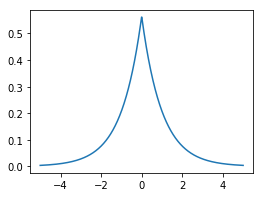

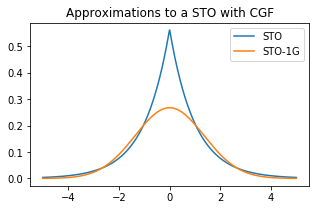

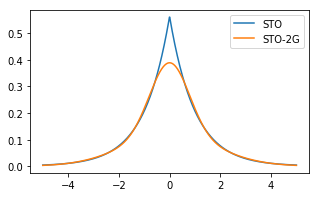

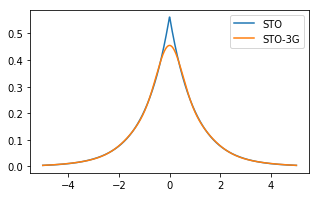

In [123]:
# Need to import some libraries to have the maths functions and plotting
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
#%matplotlib notebook # Allows plotting in the notebook

x = np.linspace(-5,5,num=1000)
r = abs(x)

zeta = 1.0

psi_STO = (zeta**3/np.pi)**(0.5)*np.exp(-zeta*r)

plt.figure(figsize=(4,3))
plt.plot(x,psi_STO)

# Coeff is the d_n variable in the equation above
Coeff = np.array([[1.00000,0.0000000,0.000000],
                  [0.678914,0.430129,0.000000],
                  [0.444635,0.535328,0.154329]])

# Expon is the alpha variable in the equation above
Expon = np.array([[0.270950,0.000000,0.000000],
                  [0.151623,0.851819,0.000000],
                  [0.109818,0.405771,2.227660]]) 

psi_CGF_STO1G = Coeff[0,0]*(2*Expon[0,0]/np.pi)**(0.75)*np.exp(-Expon[0,0]*r**2)

psi_CGF_STO2G = Coeff[1,0]*(2*Expon[1,0]/np.pi)**(0.75)*np.exp(-Expon[1,0]*r**2) \
                + Coeff[1,1]*(2*Expon[1,1]/np.pi)**(0.75)*np.exp(-Expon[1,1]*r**2) \
                + Coeff[1,2]*(2*Expon[1,2]/np.pi)**(0.75)*np.exp(-Expon[1,2]*r**2)

psi_CGF_STO3G = Coeff[2,0]*(2*Expon[2,0]/np.pi)**(0.75)*np.exp(-Expon[2,0]*r**2) \
                + Coeff[2,1]*(2*Expon[2,1]/np.pi)**(0.75)*np.exp(-Expon[2,1]*r**2) \
                + Coeff[2,2]*(2*Expon[2,2]/np.pi)**(0.75)*np.exp(-Expon[2,2]*r**2)
    
# Plot the three functions
plt.figure(figsize=(5,3))
plt.title("Approximations to a STO with CGF")
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO1G,label="STO-1G")
plt.legend()

plt.figure(figsize=(5,3))
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO2G,label="STO-2G")
plt.legend()

plt.figure(figsize=(5,3))
plt.plot(x,psi_STO,label="STO")
plt.plot(x,psi_CGF_STO3G,label="STO-3G")
plt.legend()

In [126]:
for p in range(3):
    for q in range(p+1):
        print(p,q)

0 0
1 0
1 1
2 0
2 1
2 2


In [125]:
for p in range(3):
    for q in range(3):
        print(p,q)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
